In [1]:
import numpy as np
import yaml
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits


from gammapy.data import DataStore
from gammapy.maps import MapAxis,  WcsGeom
from gammapy.datasets import MapDataset
from gammapy.estimators.utils import find_peaks
from gammapy.makers import MapDatasetMaker

In [2]:
runlist = [18415, 80170]

with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
hessera = 'hess1'

N_bins=76+1
energy_bins = np.logspace(-1, 2, N_bins)

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
observations = ds.get_observations(runlist)

No HDU found matching: OBS_ID = 18415, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 80170, HDU_TYPE = rad_max, HDU_CLASS = None


In [3]:
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
geom = WcsGeom.create(skydir=SkyCoord(0,0, unit='deg'), binsz=cfg['binsz'], width=6* u.deg, axes=[axis], frame='icrs')        
spatial_bins = np.linspace(-3,3,76)

In [4]:
dataset_list = []
for obs in observations:
    data=np.zeros((N_bins-1, 75, 75))
    for i in range(N_bins-1):
        ev = obs.events.select_energy([energy_bins[i], energy_bins[i+1]]*u.TeV)
        if len(ev.table) != 0:
            data[i, :, :] = np.histogram2d(ev.table['FOV_ALTAZ_LON'].data, ev.table['FOV_ALTAZ_LAT'].data, bins=[spatial_bins, spatial_bins])[0]
            
    dataset = MapDataset.create(geom=geom)
    dataset.counts.data = data
    
    s = find_peaks(dataset.counts.sum_over_axes(), threshold=15, min_distance="0.25 deg")
    dataset.mask_fit = ~dataset.counts.geom.region_mask(f"icrs;circle({s[0]['ra']}, {s[0]['dec']}, 0.4)")
    #dataset.counts.data *= dataset.mask_fit.data
    dataset_list.append(dataset)

In [12]:
geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=6* u.deg, frame="icrs", axes=[axis])        
dataset_bkg = MapDataset.create(geom=geom)
dataset_bkg = MapDatasetMaker().run(dataset_bkg, obs)

bg = fits.open(f'/home/woody/caph/mpp227/FITS/fitsdata/bgmodel/prod05/std_zeta_fullEnclosure/hess1_hess2/v05c/bg_model_alt1_az0.fits.gz')
dataset_bkg.background.data = ((bg['BACKGROUND'].data)['BKG'])[0]

Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


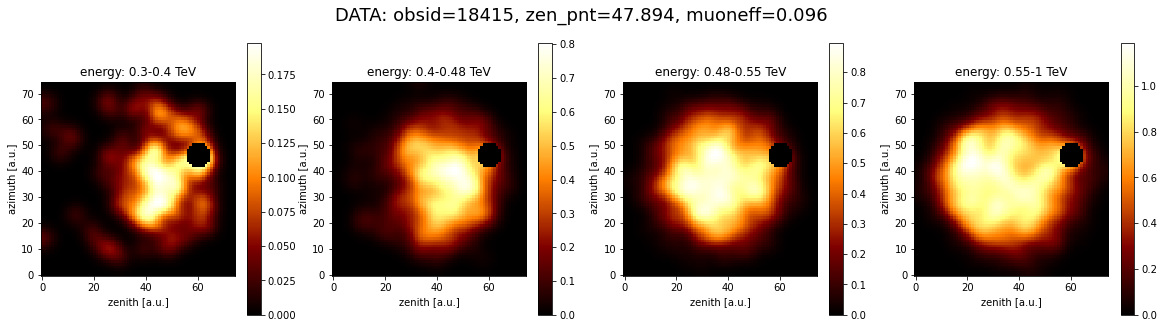

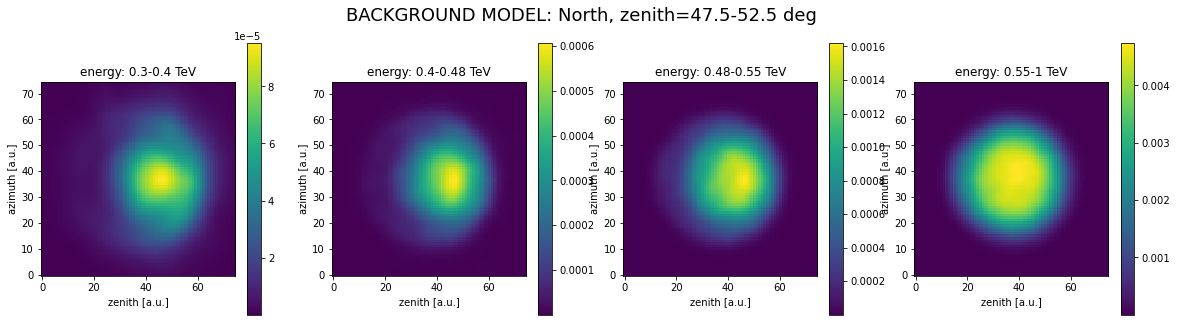

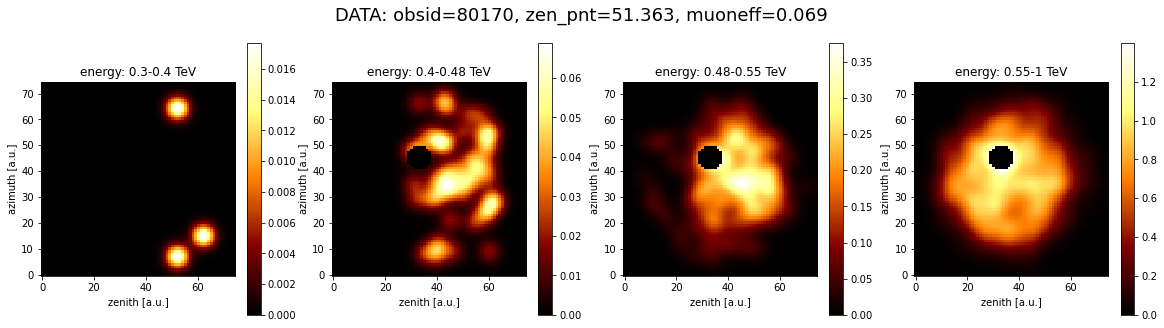

In [37]:

e_range=[[0.3, 0.4], [0.4, 0.48], [0.48, 0.55], [0.55, 1]]

for l in range(3):
    fig, ax = plt.subplots(1,4, figsize=(20, 5))
    for col in range(4):
        ax[col].set_ylabel('azimuth [a.u.]')
        ax[col].set_xlabel('zenith [a.u.]')
        ax[col].set_title(f'energy: {e_range[col][0]}-{e_range[col][1]} TeV')
        
        
        if l==1:
            #vmax=np.max(dataset_bkg.slice_by_energy(energy_min= e_range[col][0]*u.TeV, energy_max= e_range[col][1]*u.TeV).background.sum_over_axes().data)
            (dataset_bkg.slice_by_energy(energy_min= e_range[col][0]*u.TeV, energy_max= e_range[col][1]*u.TeV)).background.sum_over_axes().plot(add_cbar=True, cmap='viridis', ax=ax[col], vmax=vmax) 
            plt.suptitle(f'BACKGROUND MODEL: North, zenith=47.5-52.5 deg', size=18)
        else:
            if l == 0:
                idx=0
                vmax=np.max((dataset_list[idx].slice_by_energy(energy_min= e_range[col][0]*u.TeV, energy_max= e_range[col][1]*u.TeV)).counts.sum_over_axes().smooth(5).data)
                vmax=None
            elif l == 2:
                idx=1
            plt.suptitle(f'DATA: obsid={observations[idx].obs_id}, zen_pnt={observations[idx].obs_info["ZEN_PNT"]:.3f}, muoneff={observations[idx].obs_info["MUONEFF"]:.3f}', size=18)
                
            mask = dataset_list[idx].slice_by_energy(energy_min= e_range[col][0]*u.TeV, energy_max= e_range[col][1]*u.TeV).mask_fit
            ((dataset_list[idx].slice_by_energy(energy_min= e_range[col][0]*u.TeV, energy_max= e_range[col][1]*u.TeV)).counts.smooth(3)*mask).sum_over_axes().plot(add_cbar=True, ax=ax[col], vmax=vmax)
            
    plt.show()